In [94]:
import os
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter, map_coordinates, affine_transform
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [77]:
# load an image
filepath = "inputs/simple_smiley.png"
im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
# remove alpha channel from image
im = 255 - im[:, :, 3]

In [86]:
def generate_euclidean_grid_image(grid_size, line_width, background_color, grid_color):
    image = np.ones((grid_size, grid_size)) * background_color
    for i in range(grid_size):
        if i % line_width == 0:
            image[i, :] = grid_color
            image[:, i] = grid_color
    image[-1, :] = grid_color
    image[:, -1] = grid_color
    return image

# Parameters for the grid image
grid_size = im.shape[0]          # Size of the grid image (height and width)
line_width = 25          # Width of the grid lines
background_color = 255   # Background color (white)
grid_color = 0.0         # Grid color (black)

# Generate the Euclidean grid image
grid_image = generate_euclidean_grid_image(grid_size, line_width, background_color, grid_color)

[[-1.0000000e+00 -1.2246468e-16  5.0000000e+02]
 [ 1.2246468e-16 -1.0000000e+00  5.0000000e+02]]


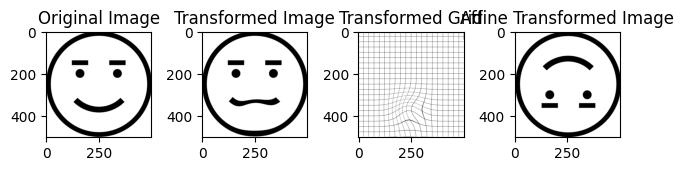

True

In [103]:
def generate_gaussian_field(shape, mean, std_dev, centre):
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    gaussian_field = np.exp(-((x - centre[1]) ** 2 + (y - centre[0]) ** 2) / (2 * std_dev ** 2))
    gaussian_field = (gaussian_field - np.min(gaussian_field)) / (np.max(gaussian_field) - np.min(gaussian_field))  # Normalize
    gaussian_field = gaussian_field * std_dev + mean
    return gaussian_field


def elastic_transform(image, alpha, sigma, centre):
    translation = -10
    random_state = np.random.RandomState(None)

    shape = image.shape
    dx = generate_gaussian_field(shape, alpha, sigma, centre)
    dy = generate_gaussian_field(shape, alpha, sigma, centre)

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing="ij")
    indices = np.reshape(x + dx, (-1, 1)) + translation, np.reshape(y + dy, (-1, 1)) + translation

    distorted_image = map_coordinates(image, indices, order=1, mode="constant", cval=255)
    return distorted_image.reshape(image.shape), indices

# Parameters for elastic transformation
alpha = 10  # Scale of deformation
sigma = 50.0  # Standard deviation

# Apply elastic transformation
shape = im.shape
centre = (370, 240)
transformed_image, indices = elastic_transform(im, alpha, sigma, centre)
transformed_grid = map_coordinates(grid_image, indices, order=1, mode="constant", cval=255)
transformed_grid = transformed_grid.reshape(im.shape)

# apply affine transformation
matrix = cv2.getRotationMatrix2D((shape[0]//2, shape[1]//2), -180, 1)
print(matrix)

# Apply the affine transformation
affine_transformed_image = cv2.warpAffine(im, matrix, (shape[1], shape[0]), borderValue=255)

# Display original and transformed images
plt.subplot(1, 4, 1)
plt.imshow(im, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(transformed_image, cmap='gray')
plt.title('Transformed Image')

plt.subplot(1, 4, 3)
plt.imshow(transformed_grid, cmap='gray')
plt.title('Transformed Grid')

plt.subplot(1, 4, 4)
plt.imshow(affine_transformed_image, cmap='gray')
plt.title('Affine Transformed Image')

plt.tight_layout()
plt.show()

cv2.imwrite("outputs/original.png", im)
cv2.imwrite("outputs/deformed_im.png", transformed_image)
cv2.imwrite("outputs/affine_transformed.png", affine_transformed_image)
cv2.imwrite("outputs/deformed_grid.png", transformed_grid)


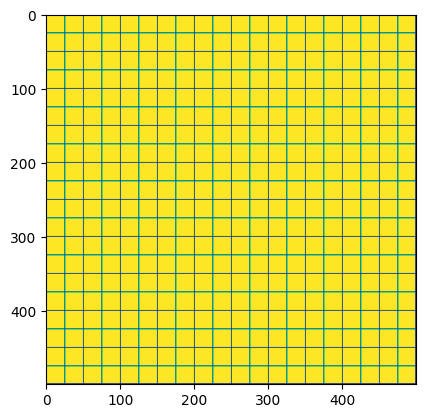

In [92]:
plt.imshow(grid_image)